# Notebook for building and evaluating LSN

* **Data shapes**
    - X_MR: samples x 2 x ROIs (baseline and follow-up) 
    - X_aux: samples x 4 (gentic, age, clinical_score_bl, clinical_score_followup) #Can be user defined
    - y: samples x n_classes (needs to be one-hot i.e. [0,1] )
    
    
* **network architecture names**
    - MR_shape: number of MR ROIs
    - n_layers: number of layers for MR Siamese net
    - l1,l2, etc: number of nodes in each layer
    - MR_output: number of output nodes (embedding dimension) for each MR branch (baseline, follow-up)
    - use_aux: LSN can be built just with MR or MR + aux_features
    - aux_shape: number of aux features excluding genetic (i.e. apoe4 status)  
    - aux_output: number nodes for aux output (single layer ANN) 
    - output: final output of LSN == number of classes 
    - reg: weight regulalization for the network 
    - Example: net_arch = {'MR_shape':78,'n_layers':4,'l1':50,'l2':50,'l3':50,'l4':25,'MR_output':20,'use_aux':True,'aux_shape':3,'aux_output':2,'output':2,'reg':0.01}

In [7]:
# Basic imports
%matplotlib inline
import sys
print(sys.version)
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import datetime
import _datetime
import time
import math
from datetime import timedelta
import sys 
import os
import pickle
sys.path.append(os.path.relpath("../lib/"))
from lsn import *

print(sys.version)
print(pd.show_versions())
print(_datetime.date.today())

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]

INSTALLED VERSIONS
------------------
commit: None
python: 3.6.6.final.0
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 166 Stepping 0, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.23.4
pytest: None
pip: 20.3.3
setuptools: 52.0.0.post20210125
Cython: None
numpy: 1.19.2
scipy: 1.5.2
pyarrow: None
xarray: None
IPython: 7.16.1
sphinx: None
patsy: None
dateutil: 2.8.1
pytz: 2021.1
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 3.3.4
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml: None
bs4: 4.9.3
html5lib: None
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.11.3
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
None
2021-03-26


# Real CT + aux data example

In [8]:
class Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        '''This method gets called for every module pickle tries to load.'''
        # python 2 --> 3 compatibility: __builtin__ has been renamed to builtins
        if module == '__builtin__':
            module = 'builtins'
        # pandas compatibility: in newer versions, pandas.indexes has been moved to pandas.core.indexes
        if 'pandas.indexes' in module:
            module = module.replace('pandas.indexes', 'pandas.core.indexes')
        if 'copy_reg' in module:
            module = module.replace('copy_reg', 'copyreg')
        if 'sklearn.cross_validation' in module:
            module = module.replace('sklearn.cross_validation', 'sklearn.model_selection')
        __import__(module)
        return getattr(sys.modules[module], name)

    

kfold_dir = "C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl"
#C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl
# pre_kfold_dir = "C:/Users/aayus/Documents/GitHub/LSN/notebooks/PreKFold/ADNI_UCD_WMH_09_01_20.csv

# #code commented out below is how i got patients
# num_patients = 8000
# num_timepoints = 2
# subjects_needed= list()
# timepoints = ["m06", "m12"]
# count = numpy.full((num_patients,num_timepoints), -4.0)
# vals = list()
# #double check later that you row[21] is correct
# with open(pre_kfold_dir, 'rt') as f:
#     reader = csv.reader(f, delimiter=',')
#     for row in reader:
#         if(row[1] == 'RID'):
#             continue
#         index = 0
#         for i in range(len(timepoints)):
#             if(timepoints[i] == row[3]):
#                 index = i
#         vals.append(float(row[21]))
#         rid = int(row[1])
#         if(count[rid][index] == -4.0):
#             count[rid][index] = float(row[21])
#         else:
#             count[rid][index] = min(count[rid][index], float(row[21]))
        
# print("yay1")

# if os.path.getsize('C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl') > 0:  
#     print("yay2")
#     with open('C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl', "rb") as f:
#         unpickler = pickle.Unpickler(f, encoding = 'bytes')
#         print(unpickler)
#         # if file is not empty scores will be equal
#         # to the value unpickled
#         scores = pickle.Unpickler(f, encoding = 'bytes').load()
        
# print(scores)
        
        
# with open('C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl', 'rb') as fo:
#       exp_setup = pickle.load(fo, encoding = 'latin1')
#exp_setup = pd.read_pickle("C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_502_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl")
with open('C:/Users/aayus/Documents/GitHub/LSN/notebooks/KFolds1/Exp_802_repeated_ALL_ADNI_traj_MMSE_tp_var_tp_sKF.pkl', 'rb') as fo:
      exp_setup = Unpickler(fo, encoding = 'latin1').load()


# a=open(kfold_dir,"r").readlines() #read pickle file line by line
# print(a[1:500])

# pickle.load(open(kfold_dir, 'rb'))

# a=map(lambda x:x.replace("\r\n","\n"),a) # replace \r\n with \n

# with open(kfold_dir,"w") as j: #write back to file in binary mode
#     for i in a:
#         j.write(i)
# pickle.load(open(kfold_dir, 'rb'))
# print('exp_name: {}'.format(exp_name))
    
df = exp_setup['df']
print(df.columns)
ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')]) 
ct_cols_followup =list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])

print(ct_cols_bl)

# Just a single split (no k-fold) as an example
train_split = int(0.9*len(df))

subject_idx_test = df['PTID'][train_split:]

# Train-test splits
X_MR_train = np.stack((df[ct_cols_bl].values,df[ct_cols_followup].values),axis=1)[:train_split]
X_aux_train = df[['APOE4','AGE','MMSE_bl','MMSE_var_tp']].values[:train_split]
y_train = df['traj'].values[:train_split]
y_train = np.squeeze(np.vstack((1-y_train,y_train)).T)

X_MR_test = np.stack((df[ct_cols_bl].values,df[ct_cols_followup].values),axis=1)[train_split:]
X_aux_test = df[['APOE4','AGE','MMSE_bl','MMSE_var_tp']].values[train_split:]
y_test = df['traj'].values[train_split:]
y_test = np.squeeze(np.vstack((1-y_test,y_test)).T)

print(X_MR_train)

print('shapes of X_MR_train:{}, X_aux_train:{}, y_train:{}, \n\t X_MR_test:{}, X_aux_test:{}, y_test:{}'.format(X_MR_train.shape,X_aux_train.shape,y_train.shape,
                                                                                                                X_MR_test.shape,X_aux_test.shape,y_test.shape)) 

Index(['Unnamed: 0', 'PTID', 'AGE', 'APOE4', 'PTGENDER', 'DX_bl',
       'PreCG.L_CT_bl', 'PreCG.R_CT_bl', 'SFGdor.L_CT_bl', 'SFGdor.R_CT_bl',
       ...
       'TPOsup.R_CT_rate', 'MTG.L_CT_rate', 'MTG.R_CT_rate',
       'TPOmid.L_CT_rate', 'TPOmid.R_CT_rate', 'ITG.L_CT_rate',
       'ITG.R_CT_rate', 'traj', 'ORIGPROT', 'strata'],
      dtype='object', length=248)
['PreCG.L_CT_bl', 'PreCG.R_CT_bl', 'SFGdor.L_CT_bl', 'SFGdor.R_CT_bl', 'ORBsup.L_CT_bl', 'ORBsup.R_CT_bl', 'MFG.L_CT_bl', 'MFG.R_CT_bl', 'ORBmid.L_CT_bl', 'ORBmid.R_CT_bl', 'IFGoperc.L_CT_bl', 'IFGoperc.R_CT_bl', 'IFGtriang.L_CT_bl', 'IFGtriang.R_CT_bl', 'ORBinf.L_CT_bl', 'ORBinf.R_CT_bl', 'ROL.L_CT_bl', 'ROL.R_CT_bl', 'SMA.L_CT_bl', 'SMA.R_CT_bl', 'OLF.L_CT_bl', 'OLF.R_CT_bl', 'SFGmed.L_CT_bl', 'SFGmed.R_CT_bl', 'ORBsupmed.L_CT_bl', 'ORBsupmed.R_CT_bl', 'REC.L_CT_bl', 'REC.R_CT_bl', 'INS.L_CT_bl', 'INS.R_CT_bl', 'ACG.L_CT_bl', 'ACG.R_CT_bl', 'DCG.L_CT_bl', 'DCG.R_CT_bl', 'PCG.L_CT_bl', 'PCG.R_CT_bl', 'PHG.L_CT_bl', 'PHG.R_C

In [9]:
# Check differences in aux_feature distributions
print('train aux distributions')
class_0 = np.mean(X_aux_train[y_train[:,0]==0],axis=0)
class_1 = np.mean(X_aux_train[y_train[:,0]==1],axis=0)
print(class_0,class_1)
print('test aux distributions')
class_0 = np.mean(X_aux_test[y_test[:,0]==0],axis=0)
class_1 = np.mean(X_aux_test[y_test[:,0]==1],axis=0)
print(class_0,class_1)

train aux distributions
[ 0.81   74.741  25.21   23.3225] [ 0.41059603 72.78642384 28.80298013 28.81291391]
test aux distributions
[ 0.85714286 75.76666667 25.4047619  24.07142857] [ 0.27142857 73.38       28.6        28.78571429]


# Train and test a sample LSN

**Note there is no hyper param tuning in this example **

In [14]:
# training params
lr = 0.001
n_epochs = 100
validate_after = 10
batch_size = 100
dropout = 0.75 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 
save_model = False # If you want to save the model to the disk (not needed usually)
save_model_path = '/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/TF_trained_models/'

net_arch = {'MR_shape':78,'n_layers':3,'l1':25,'l2':25,'l3':25,'l4':25,'l5':25,'MR_output':10,
            'use_aux':True,'aux_shape':4,'aux_output':10,'output':2, 'reg':0.01}

# minimal perf df --> append CV related attributes downstream. 
perf_df = pd.DataFrame(columns=['subject_id','label','pred_prob','pred_label'])

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    
    # ----------------------Train model    -------------------------------
    data = {'X_MR':X_MR_train,'X_aux':X_aux_train,'y':y_train}    
    if check_data_shapes(data,net_arch):      
        print('train data <-> net_arch check passed')   
        lsn = siamese_net(net_arch)        
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
        tf.global_variables_initializer().run()
        saver = tf.train.Saver()
        
        cur_time = datetime.datetime.now()
        print('\nStart training time: {}'.format(cur_time))                
        lsn, train_metrics = train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout,validate_after,verbose)
        
        # Save trained model
        # See at the end of this notebook for the code for using pretrained model 
        if save_model:
            print('saving model at {}'.format(save_model_path + 'lsn_example'))
            saver.save(sess, save_model_path + 'lsn_example')
            
        cur_time = datetime.datetime.now()
        print('End training time: {}\n'.format(cur_time))  
      
    else:
        print('train data <-> net_arch check failed')

    # Test model  (within same session)         
    data = {'X_MR':X_MR_test,'X_aux':X_aux_test,'y':y_test}
    if check_data_shapes(data,net_arch):
        print('test data <-> net_arch check passed')   
        _,test_metrics = test_lsn(sess,lsn,data)        
        # populate perf dataframe
        perf_df['subject_id']  = subject_idx_test
        perf_df['label'] = np.argmax(y_test,1)
        perf_df['pred_prob'] = list(test_metrics['test_preds'])
        perf_df['pred_label'] = np.argmax(test_metrics['test_preds'],1)
    else:
        print('test data <-> net_arch check failed')   


train data <-> net_arch check passed




Using MR and aux features


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Start training time: 2021-03-26 09:55:33.358489
performance on entire train and valid subsets
epoch 0	 train_acc:0.4121547043323517	 valid_acc:0.4545454680919647

performance on entire train and valid subsets
epoch 10	 train_acc:0.8121547102928162	 valid_acc:0.7676767706871033

performance on entire train and valid subsets
epoch 20	 train_acc:0.8950276374816895	 valid_acc:0.8888888955116272

performance on entire train and valid subsets
epoch 30	 train_acc:0.9259668588638306	 valid_acc:0.9191918969154358

performance on entire train and valid subsets
epoch 40	 train_acc:0.9425414204597473	 valid_acc:0.939393937587738

performance on entire train and valid subsets
epoch 50	 train_acc:0.9480662941932678	 valid_acc:0.9191918969154358

performance on entire train and valid subsets
epoch 60	 train_acc:

# Plots

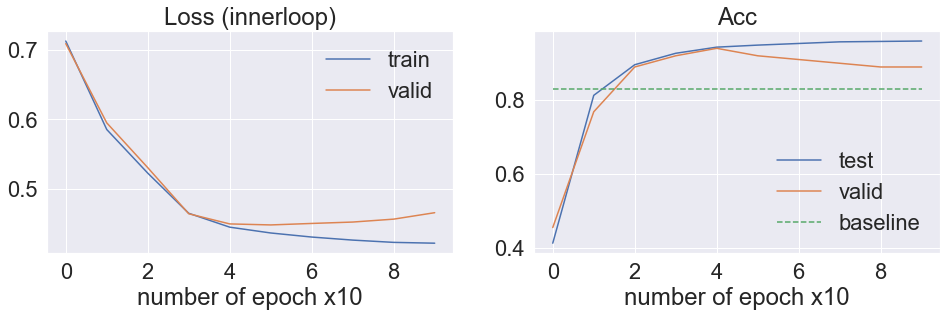

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

plt.figure(figsize=(16,9))
plt.style.use('seaborn-white')
sns.set(font_scale=2)
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
train_acc = train_metrics['train_acc']
valid_acc = train_metrics['valid_acc']

plt.subplot(2,2,1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.title('Loss (innerloop)')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_acc,label='test');
plt.plot(valid_acc,label='valid');
plt.plot(np.tile(test_metrics['test_acc'],len(train_acc)),'--',label='baseline')
plt.title('Acc')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

10
[[ 3.59290195e+00  1.38462200e+01]
 [-9.34245765e-01  2.07866001e+01]
 [-6.92186451e+00 -1.79064045e+01]
 [-1.48831177e+01  2.33190308e+01]
 [ 9.01962471e+00 -1.53862276e+01]
 [-6.55052376e+00  2.72282925e+01]
 [ 2.11635232e+00 -1.84104176e+01]
 [-1.11951599e+01 -2.08394146e+01]
 [ 1.20329599e+01 -1.63256359e+01]
 [-1.22215309e+01 -2.29616528e+01]
 [ 1.47969782e+00  1.56174984e+01]
 [-3.28798342e+00 -4.66151094e+00]
 [ 1.96299386e+00  2.46075554e+01]
 [-6.12087154e+00  2.71435413e+01]
 [-7.15214729e+00  1.60761604e+01]
 [-8.48162353e-01  3.11983132e+00]
 [ 5.04715347e+00  5.78606749e+00]
 [ 4.22422552e+00  2.69311886e+01]
 [-6.19067383e+00  9.59138393e+00]
 [ 7.18211126e+00 -1.52990780e+01]
 [ 5.53101826e+00 -1.57212601e+01]
 [-6.29730701e+00 -1.85010109e+01]
 [ 8.84835052e+00 -1.38626432e+01]
 [ 2.48876357e+00  2.54617844e+01]
 [-1.53886223e+01 -2.26452208e+00]
 [ 1.32294881e+00 -1.78566322e+01]
 [-3.22382450e+00 -5.92561901e-01]
 [-2.95878863e+00 -1.29601698e+01]
 [-4.45825291e+00

C:\Users\aayus\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


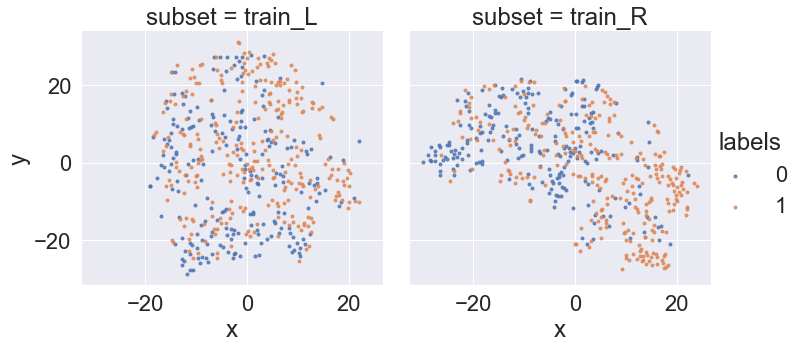

In [16]:
#Plot TSNE
tsne_sampx = 500 #Too slow for large number of samples
train_embed_L = train_metrics['train_feature_L']
train_embed_R = train_metrics['train_feature_R']
print(len(train_embed_L[0]))
test_embed_L = test_metrics['test_feature_L']
test_embed_R = test_metrics['test_feature_R']

train_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(train_embed_L[:tsne_sampx])
test_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(test_embed_L[:tsne_sampx])
train_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(train_embed_R[:tsne_sampx])
test_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(test_embed_R[:tsne_sampx])

print(train_tsne_embed_L)

train_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
train_df_R = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_R = pd.DataFrame(columns=['x','y','labels','subset'])

train_df_L['x'] = train_tsne_embed_L[:,0] 
train_df_L['y'] = train_tsne_embed_L[:,1] 
train_df_L['labels'] = y_train[:tsne_sampx]
train_df_L['subset'] = np.tile('train_L',len(y_train[:tsne_sampx]))

train_df_R['x'] = train_tsne_embed_R[:,0] 
train_df_R['y'] = train_tsne_embed_R[:,1] 
train_df_R['labels'] = y_train[:tsne_sampx]
train_df_R['subset'] = np.tile('train_R',len(y_train[:tsne_sampx]))

test_df_L['x'] = test_tsne_embed_L[:,0] 
test_df_L['y'] = test_tsne_embed_L[:,1] 
test_df_L['labels'] = y_test[:tsne_sampx]
test_df_L['subset'] = np.tile('test_L',len(y_test[:tsne_sampx]))

test_df_R['x'] = test_tsne_embed_R[:,0] 
test_df_R['y'] = test_tsne_embed_R[:,1] 
test_df_R['labels'] = y_test[:tsne_sampx]
test_df_R['subset'] = np.tile('test_R',len(y_test[:tsne_sampx]))


plot_df = train_df_L.append(train_df_R)
plot_df1 = test_df_L.append(test_df_R)
sns.lmplot(x='x',y='y',hue='labels',col='subset',col_wrap=2, fit_reg=False, markers='.',data=plot_df,size=5);

[[0.8590068  0.1409932 ]
 [0.89216346 0.10783648]
 [0.09966177 0.90033823]
 ...
 [0.28196406 0.7180359 ]
 [0.18357755 0.8164224 ]
 [0.11243447 0.8875655 ]]
112
[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


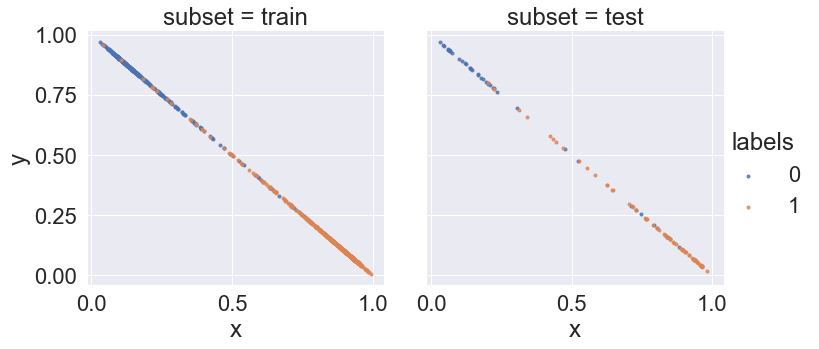

In [17]:
# Plot preds
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']
print((train_features))
print(len(test_features))
print((y_test)
      

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = y_train
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = y_test
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);


# Loading previously trained model

In [0]:
# with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph(save_model_path + 'lsn_example.meta')
#     new_saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
#     _,test_metrics = test_lsn(sess,lsn,data) 